# 背景

对指定个股和指数进行30分钟级别的监控，包括趋势、反转指标等，并通过语音进行报告。

In [81]:
! export HTTPS_PROXY=""
from alpha.notebook import *
from alpha.core.rsi_stats import rsiday, rsi30
import datetime
import itertools
import traceback
from IPython.display import display
from omicron.core.numpy_extensions import find_runs
await init_notebook()

g = {
    "notified": set(),
}


In [ ]:
async def notify(frame, text, voice_only=False):
    key = f"{frame.hour:02d}:{frame.minute:02d} {text}"
    if key in g["notified"]:
        return
    
    if not voice_only:
        print(key)
    g["notified"].add(key)
    await nb_say(text)

In [ ]:
async def do_check(holdings:List[str], candidates, check_at=None):
    end = arrow.now() if check_at is None else arrow.get(check_at)
    start = tf.shift(tf.floor(end, FrameType.MIN30), -39, FrameType.MIN30)
    
    for code in itertools.chain(["000001.XSHG"], holdings):
        sec = Security(code)
        try:
            bars = await sec.load_bars(start, end, FrameType.MIN30)
        except Exception as e:
            traceback.print_exception(e)
            continue
            
        bars = bars[np.isfinite(bars["close"])]
        close = bars["close"]
        
        rsi = relative_strength_index(close, period=6)[-1]
        prsi = rsi30.get_proba(code, rsi)
                        
        
            
        if prsi >= 0.9 and code in ["000001.XSHG", *holdings]:
            await notify(end, f"相对强弱指标显示，{sec.display_name}即将高位反转，概率为百分之{prsi:.0%}.")
        if prsi <= 0.1 and code in ["000001.XSHG"]:
            await notify(end, f"相对强弱指标显示，{sec.display_name}即将低位反转，概率为百分之{1-prsi:.0%}.")
    
async def mon(holdings, check_at=None):
    import asyncio
    
    holdings = [name_to_code(name) for name in holdings]
    
    now = arrow.now()
    wakeup_time = []
    for tm in ["10:00", "10:15", "10:30", "10:45", "11:00", "11:15", "11:30", "13:15", "13:30",
              "13:45", "14:00", "14:15", "14:30", "14:45"]:
        hour, minute = map(int, tm.split(":"))
        wakeup_time.append(arrow.Arrow(now.year, now.month, now.day, hour, minute, tzinfo="Asia/Shanghai"))
        
    if check_at:
        wakeup_time.insert(0, arrow.now().shift(seconds=5))
        
    end = tf.floor(arrow.now(), FrameType.DAY)
    start = tf.day_shift(end, -40)
    
    data = []
    for code in itertools.chain(["000001.XSHG"], holdings):
        sec = Security(code)
        bars = await sec.load_bars(start, end, FrameType.DAY)
        bars = bars[np.isfinite(bars["close"])]
        
        close = bars["close"]
        rsi = relative_strength_index(close, 6)[-3:]
        prsi = [round(rsiday.get_proba('000001.XSHG', r), 2) for r in rsi]

        data.append([sec.display_name, *prsi])
        
    df = pd.DataFrame(data, columns=["name", "rsi0", "rsi1", "rsi2"])
    display(df)
    
    for tm in wakeup_time:
        if arrow.now() > tm:
            continue
            
        seconds = (tm.timestamp - arrow.now().timestamp)
        await asyncio.sleep(seconds)
        print(f"=========== {tm.hour}:{tm.minute:02d}============")
        await do_check(holdings, check_at)

In [ ]:
holdings = [
    "中国西电", 
    "格林美", 
    "中国宝安",
    "惠泉啤酒",
    "方大集团",
    "天齐锂业",
    "长城科技",
    "湖北宜化",
]
await mon(holdings, arrow.now().shift(seconds=3))
print("一天监测结束")

In [ ]:
目标：
1. 检测当前均线是否已经拐头（越过-b/(2*a))
2. 如果均线呈直线，则4周期内涨跌幅是否超过阈值（大盘0.25)

In [ ]:
pd.options.display.max_rows = 200
end = arrow.get("2021-11-05 15:00")
start = tf.shift(end, -100, FrameType.MIN30)

cs = Candlestick({'30m': [5,10,20,60]})
await cs.plot("000001.XSHG", "2021-11-05 15:00")

results = []
for frame in tf.get_frames(start, end, FrameType.MIN30):
    frame = tf.int2time(frame)
    bars = await get_bars("000001.XSHG", 25, '30m', frame)
    features = flip_features("000001.XSHG", bars["close"], FrameType.MIN30)
    row = [frame, *features]
    results.append(row)
    
pd.DataFrame(results, columns=["frame", "prsi", "rsi", "ma_direct", "to_vx", "pmae", "rlf", "bear", "bull"])

In [ ]:
# 大阴线或者连续阴线导致不规则的反转;反之亦然
bars = await get_bars("000001.XSHG", 25, '30m', "2021-10-20 13:30")
close = bars["close"]
if close[-1] < close[-6] and np.any(close[-5:-1]>close[-6]):
    long_bearish_line = True
else:
    long_bearish_line = None

if close[-1] > close[-6] and np.any(close[-5:-1]<close[-6]):
    long_bullish_line = True
else:
    long_bullish_line = None

In [ ]:
long_bearish_line

In [73]:
shday = await get_bars("000001.XSHG", 200, '1d')
shmin = await get_bars("000001.XSHG", 200, '30m')

(datetime.datetime(2021, 11, 5, 15, 0, tzinfo=tzfile('/usr/share/zoneinfo/Asia/Shanghai')), 3501.33, 3502.46, 3491.57, 3491.57, 4.8266709e+09, 6.08323715e+10, 1.)

In [6]:
close = sh["close"]
roc = close[1:]/close[:-1] - 1
df = pd.DataFrame(roc, columns=["roc"])

In [9]:
from scipy.stats import rv_histogram

hist = np.histogram(roc, bins=20, range=(-0.1, 0.1))
cdf = rv_histogram(hist)

In [ ]:
def flip_features(code, close, frame_type, ma=None):
    """
    1. rsi
    2. 抛物线转向？
    3. msr？
    """
    from alpha.core.rsi_stats import rsi30, rsiday

    if ma is None:
        ma = moving_average(close, 5)

    rsi = relative_strength_index(close, period=6)[-1]

    stats = rsi30 if frame_type == FrameType.MIN30 else rsiday
    prsi = stats.get_proba(code, rsi)

    ma_direction, dist_to_vx, a, pmae = parabolic_flip(ma, calc_ma=False)

    # 大阴线或者连续阴线导致不规则的反转;反之亦然
    if close[-1] < close[-6] and np.any(close[-5:-1]>close[-6]):
        long_bearish_line = True
    else:
        long_bearish_line = None

    if close[-1] > close[-6] and np.any(close[-5:-1]<close[-6]):
        long_bullish_line = True
    else:
        long_bullish_line = None

    return [prsi, rsi, ma_direction, dist_to_vx, pmae, rlf, long_bearish_line, long_bullish_line]

In [75]:
signals = reversal_pattern_flip("000001.XSHG", shday)
signals    

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 100,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [79]:
pos = np.argwhere(signals >= 100)
shday[pos]['frame']

array([[datetime.date(2021, 3, 26)],
       [datetime.date(2021, 11, 4)]], dtype=object)

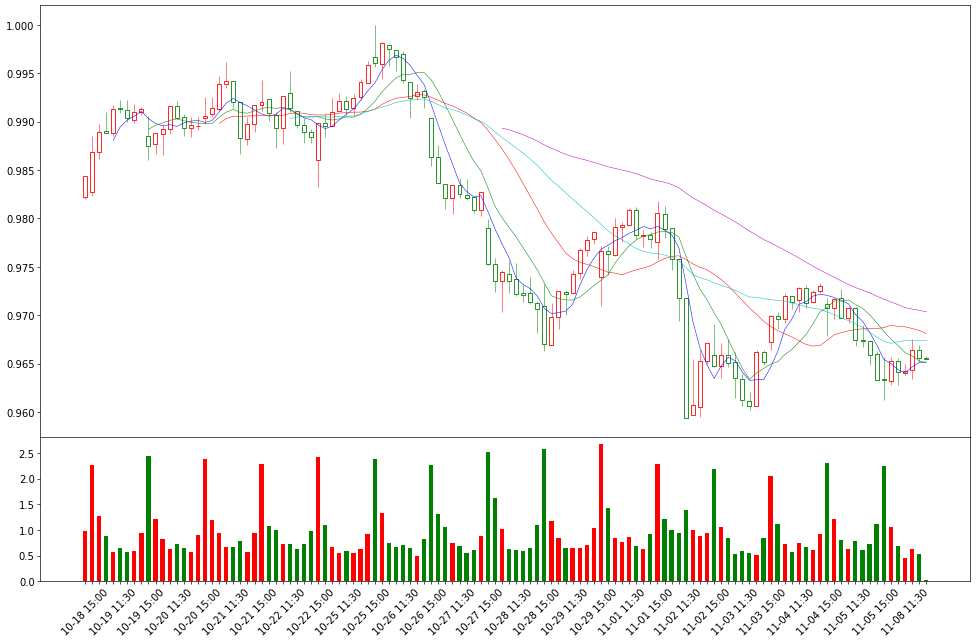

In [88]:
cs = Candlestick({"30m": [5, 10, 20, 30, 60]}, n_plot_bars = 120)
sh = await get_bars("000001.XSHG", 120, '30m')
cs.plot_bars(sh)

目标： 需要能判断

33 10-25 10:00 底
10-26 10:30 顶 RSI
10-29 10:00 底 RSI
11-02 10:00 顶 抛物线转向？要求11：00能发出信号
11-03 13:30 底
11-03 14:30 底 RSI底背离
11-04 15:00 顶 抛物线转向？

In [168]:
def check_performace(bars, pos):
    results = []
    for p in pos:
        row = []
        for n in [3, 5, 10]:
            down = min(bars[p:p+n]["close"])/bars["close"][p] - 1
            up = max(bars[p:p+n]["close"])/bars["close"][p] - 1
            
            row.extend([round(down * 100, 2), round(up * 100, 2)])
        results.append(row)
            
    return pd.DataFrame(results, columns=["min_3", "max_3", "min_5", "max_5", "min_10", "max_10"])

In [169]:
df = check_performace(sh_min_10000, pos)